# Optimizing API Calls for NYC Restaurant Data Collection: Set Coverage Problem (Spatial Query Optimization)

**By Sean Katauskas**

This project focuses on efficiently retrieving website information for all restaurants in New York City using the Google Places API. While New York City has a comprehensive database with addresses and or geographical coordinates for all its restaurants, it notably lacks website information. The goal is to use API calls to collect website URIs for these known locations. These website URIs will later be scraped for menu data that will populate a restaurant recommendation application.

The simplest way to obtain each restaurant's website URI is to perform an individual textual API search for each business using its name and/or address. Each call costs 5 cents, so for the 30,000 restaurants in NYC, the total cost would be $1,500. A more cost-effective option is to use a nearby search returning 20 restaurants URIs for 5 cents in total. Thus in best case can reduce total cost by 20x.

The Google Places Nearby Search API can return up to 20 place objects (which include website URIs) based on a given geographic coordinate and search radius. Results can be filtered by place type, such as "restaurant".

The goal is now clear: each restaurant's geographic coordinate must be captured within a nearby search call.

To optimize the process, the task is approached as a geometric set cover problem: how to cover all restaurant locations with the fewest possible API calls. Each API call represents a "circle" that can capture up to 20 restaurants, with a variable radius and center. The objective is to determine an optimized selection of circles to ensure that every restaurant in New York City is covered.

<br>
<img src="manhattan_heatmap.png" alt="Map of Restaurants in NYC" width="400">
<br>

The workflow includes the following steps:
1.   Data Preparation:

  The project starts with a raw NYC restaurant inspection database, which requires cleaning and processing to standardize the geographic coordinates of all restaurant locations.


2.   Geometric Coverage Optimization:

  Using greedy and linear programming algorithms, circles with variable radii are generated to cover all restaurant points. The goal is to minimize the total number of circles while ensuring that each contains no more than 20 restaurants, meeting the constraints of the API.


3.  Output File Generation:

  The notebook generates a file containing a list of parameters for each API call, including the latitude, longitude, and radius for each circle. This file encompasses all the API calls needed to cover every restaurant in NYC, serving as a complete blueprint for efficient data retrieval of website URIs.

# Part 0: Dependencies

In [ ]:
!pip install numpy scikit-learn pandas geopy tqdm requests matplotlib geopandas shapely scipy

# Part 1: Cleaning NYC Restaurant Inspection Data

The Department of Health and Mental Hygiene (DOHMH) of NYC maintains daily a dataset containing inspections for all active status restaurants up to three years prior to the most recent inspection date respectively. Download the dataset for the most recent version in csv format from the linked website and adjust the file path for the downloaded file.

[DOHMH NYC Restaurant Inspection Website](https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data)

The primary purpose of this effort is to ensure that all restaurants have accurate geographical coordinates.

*Note: Skip this code if you dont want to supply a Google Places API key. This part generates the most up to date dataset but is not necessary for the rest of the code as cleaned_NYC_Restaurant_Database.csv is already supplied.*


In [1]:
import os
import data_cleaning as dc

In [2]:
google_places_api_key = "yourapikey"
cleaned_dataset_filepath = "cleaned_NYC_Restaurant_Database.csv"

In [3]:
# Load Data (https://data.cityofnewyork.us/Health/DOHMH-New-York-City-Restaurant-Inspection-Results/43nn-pn8j/about_data)
file_path = 'DOHMH_New_York_City_Restaurant_Inspection_Results_20241021.csv'  # Replace with your actual file path
df = dc.load_restaurant_data(file_path)

In [ ]:
# Clean and Prepare Data
df = dc.populate_full_address(df)
df = dc.populate_missing_coordinates(df, google_places_api_key)
df = dc.refine_geocode_for_restaurants(df, google_places_api_key)

In [5]:
# Save the cleaned data
if not os.path.exists(cleaned_dataset_filepath):
    dc.export_cleaned_data(df, 'cleaned_NYC_Restaurant_Database.csv')

# Part 2: Visualizing Cleaned NYC Restaurant Data

This section presents visualizations of the cleaned NYC restaurant dataset, highlighting the spatial distribution of restaurants across the city. The aim of creating these graphs is to inspire the development of covering algorithms by visualizing spatial relationships. The visual analysis includes:

* **General Density Plot & Heat Map** display the overall distribution and density of restaurants across New York City.

* **Geographical Clustering (DBSCAN) Heat Maps** identify areas with high restaurant density, making it easier to pinpoint highly concentrated zones.

* **Voronoi Diagram** depicts the spatial distribution of restaurants, with each cell representing an area of influence for individual restaurants.

* **Delaunay Triangulation & K-Means Clustering** reveal spatial relationships through non-overlapping triangles and distinct geographical clusters.

*Note: If you are skipping the data cleaning steps in part 1, ensure that the file path to the cleaned NYC restaurant data (CSV format) is updated accordingly in the next code cell.*

In [5]:
import os
from utils import load_csv
import visualizations as vs

cleaned_dataset_filepath = "cleaned_NYC_Restaurant_Database.csv"

df = load_csv(cleaned_dataset_filepath)
gdf = vs.create_geodataframe(df)

if not os.path.exists('boroughs') and not os.path.exists('streets'):
    vs.download_streets_boroughs_shapefiles()
    
nyc_streets, nyc_boroughs = vs.load_shapefiles()

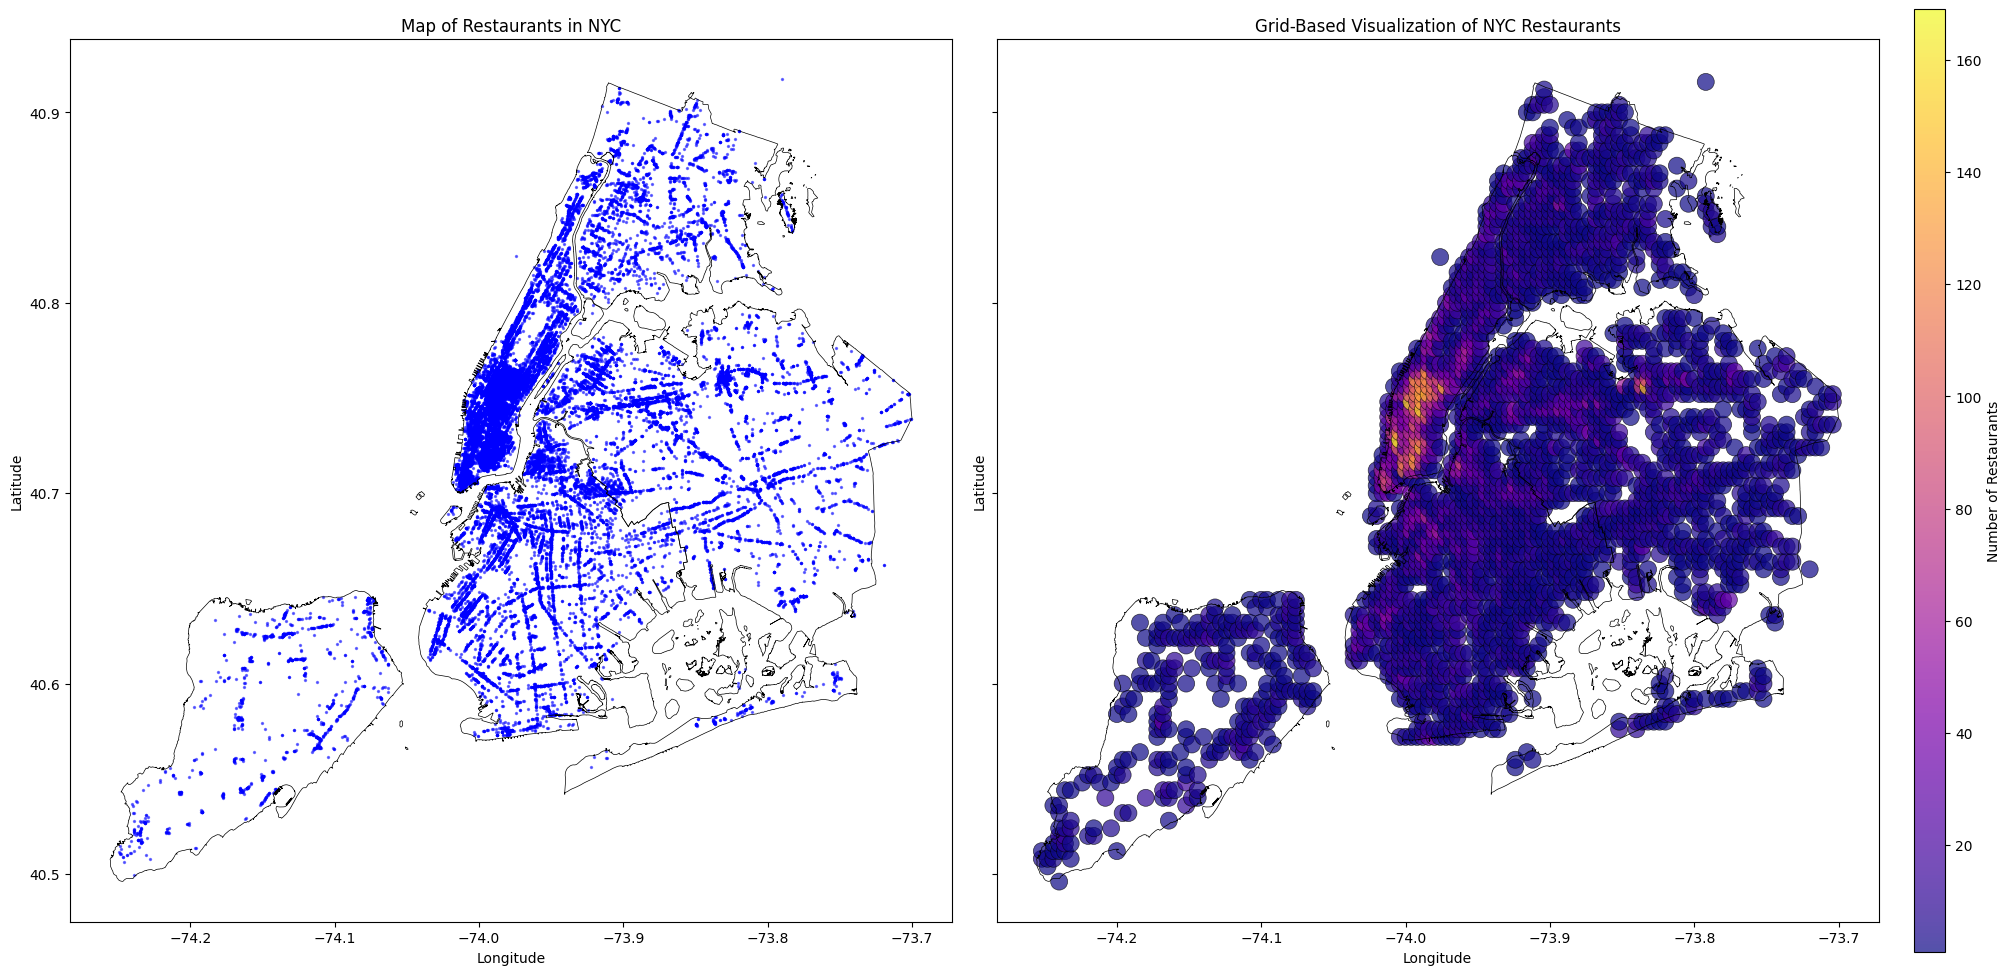

In [6]:
# General Density and Heat Map Plot
vs.plot_general_density_and_heatmap(gdf, nyc_boroughs, grid_size=0.004)

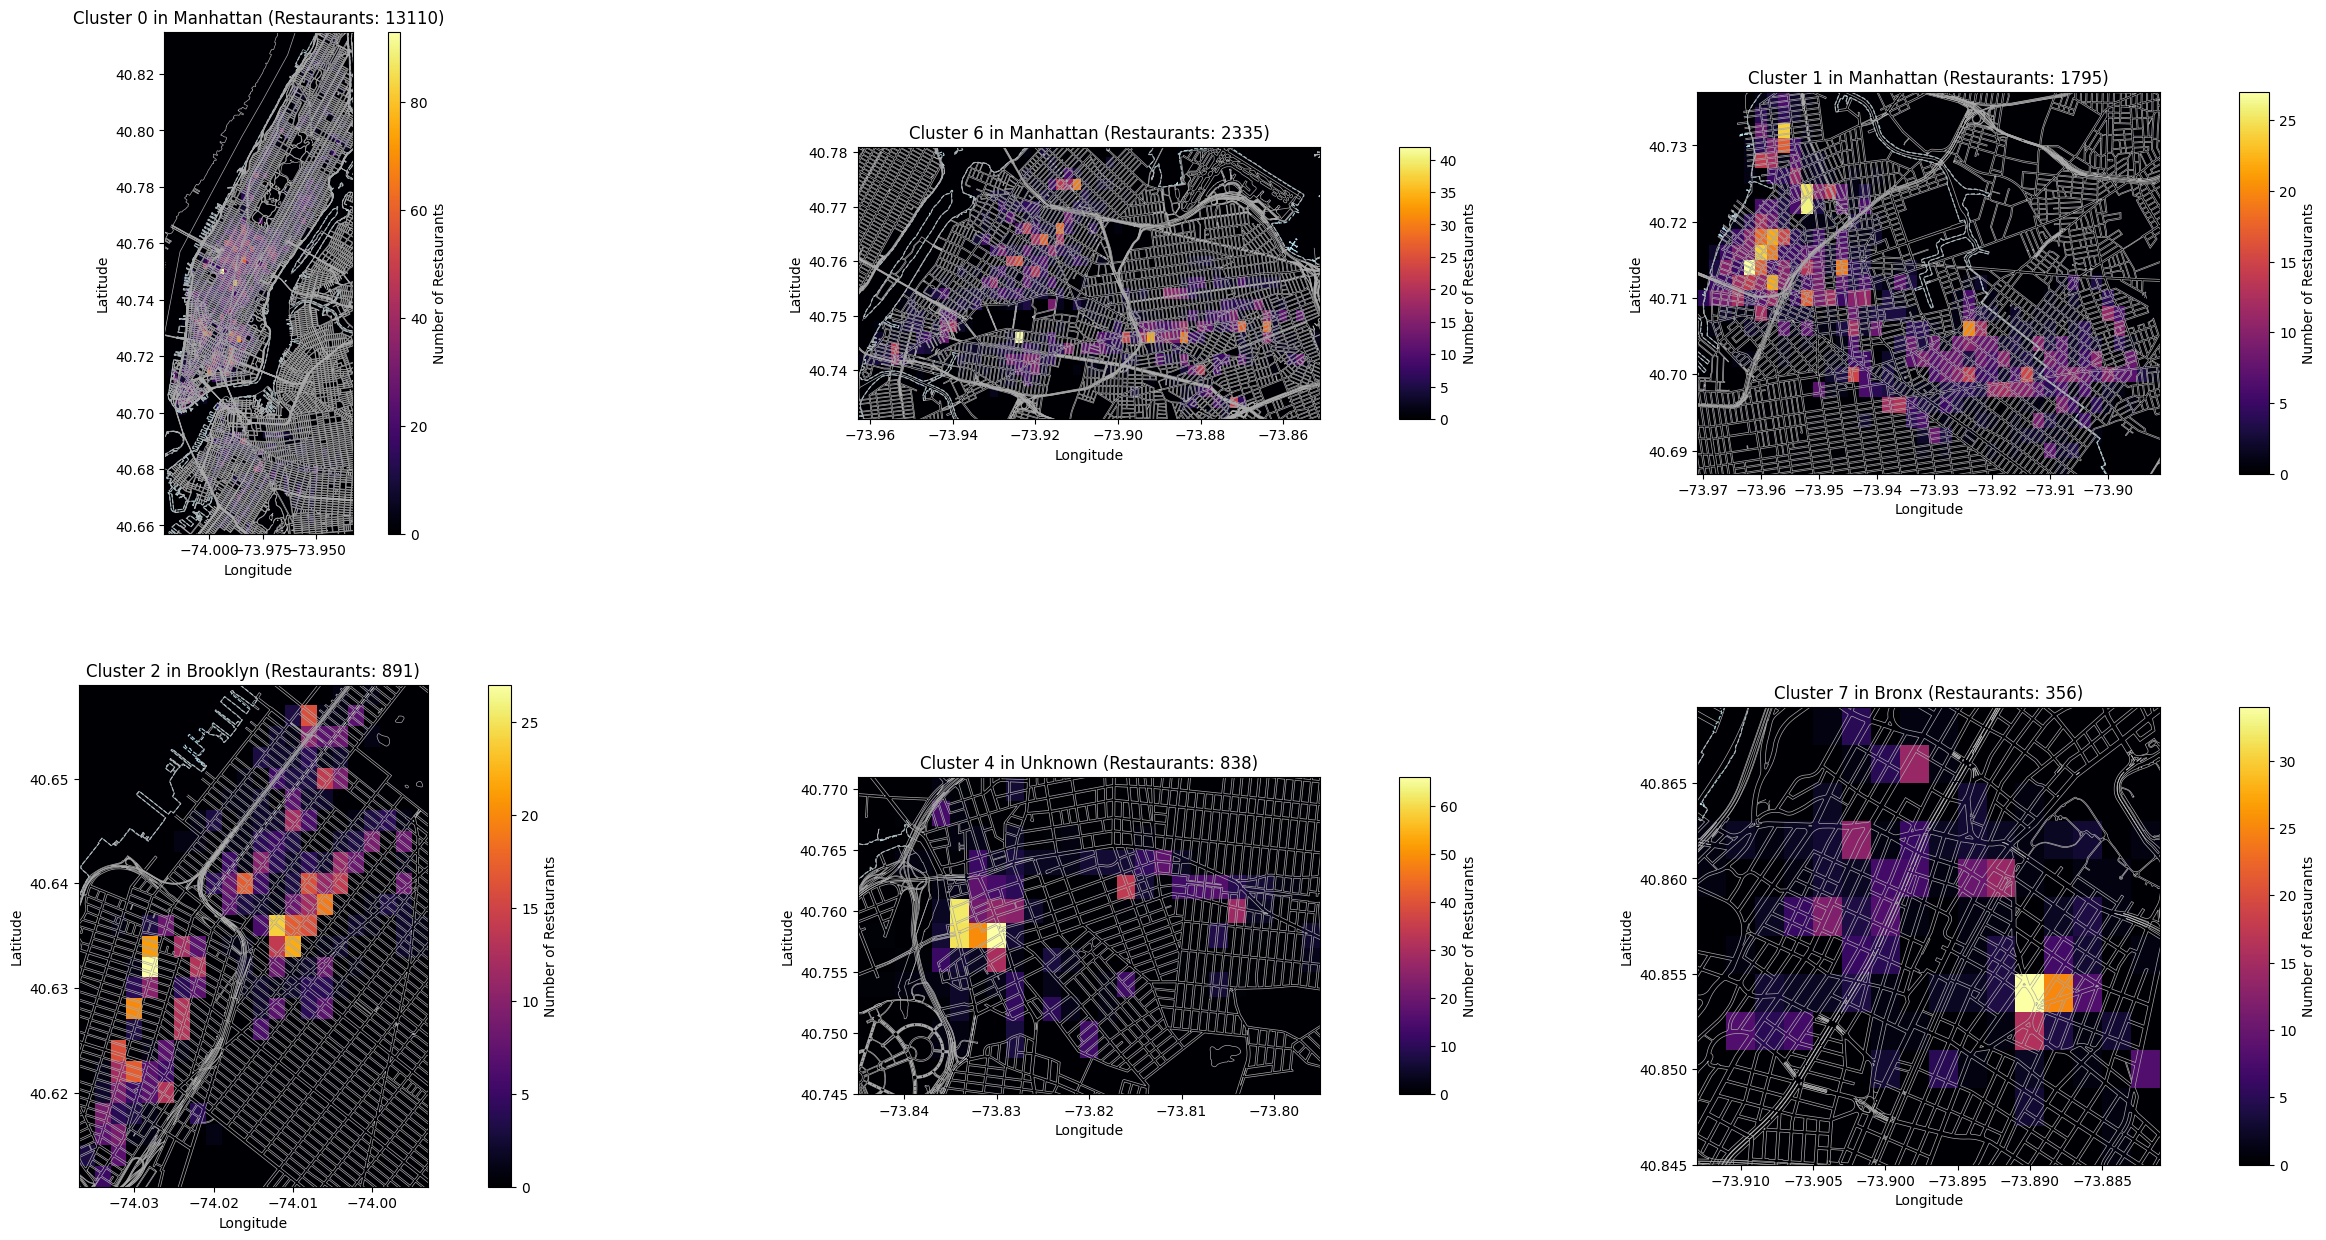

In [3]:
# DBSCAN Clustering Heat Map Plot
vs.plot_dbscan_clusters(gdf, nyc_boroughs, nyc_streets, eps=0.0001, min_samples=100, grid_size=0.002)

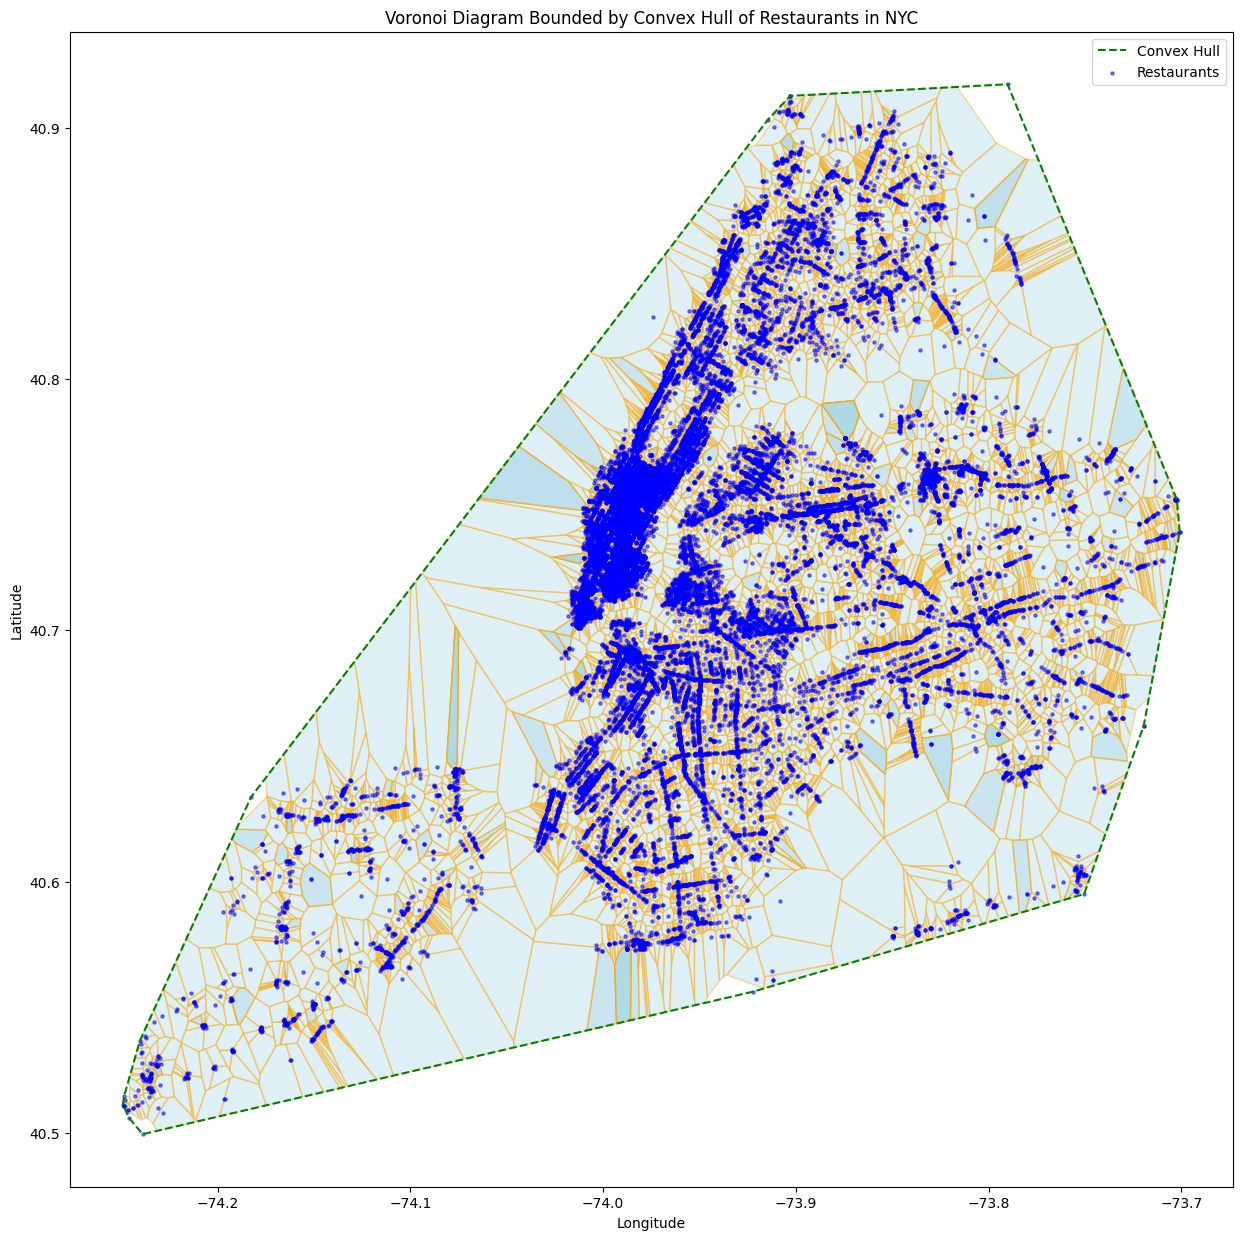

In [4]:
# Voronoi Diagram Plot
vs.plot_voronoi_diagram(gdf)

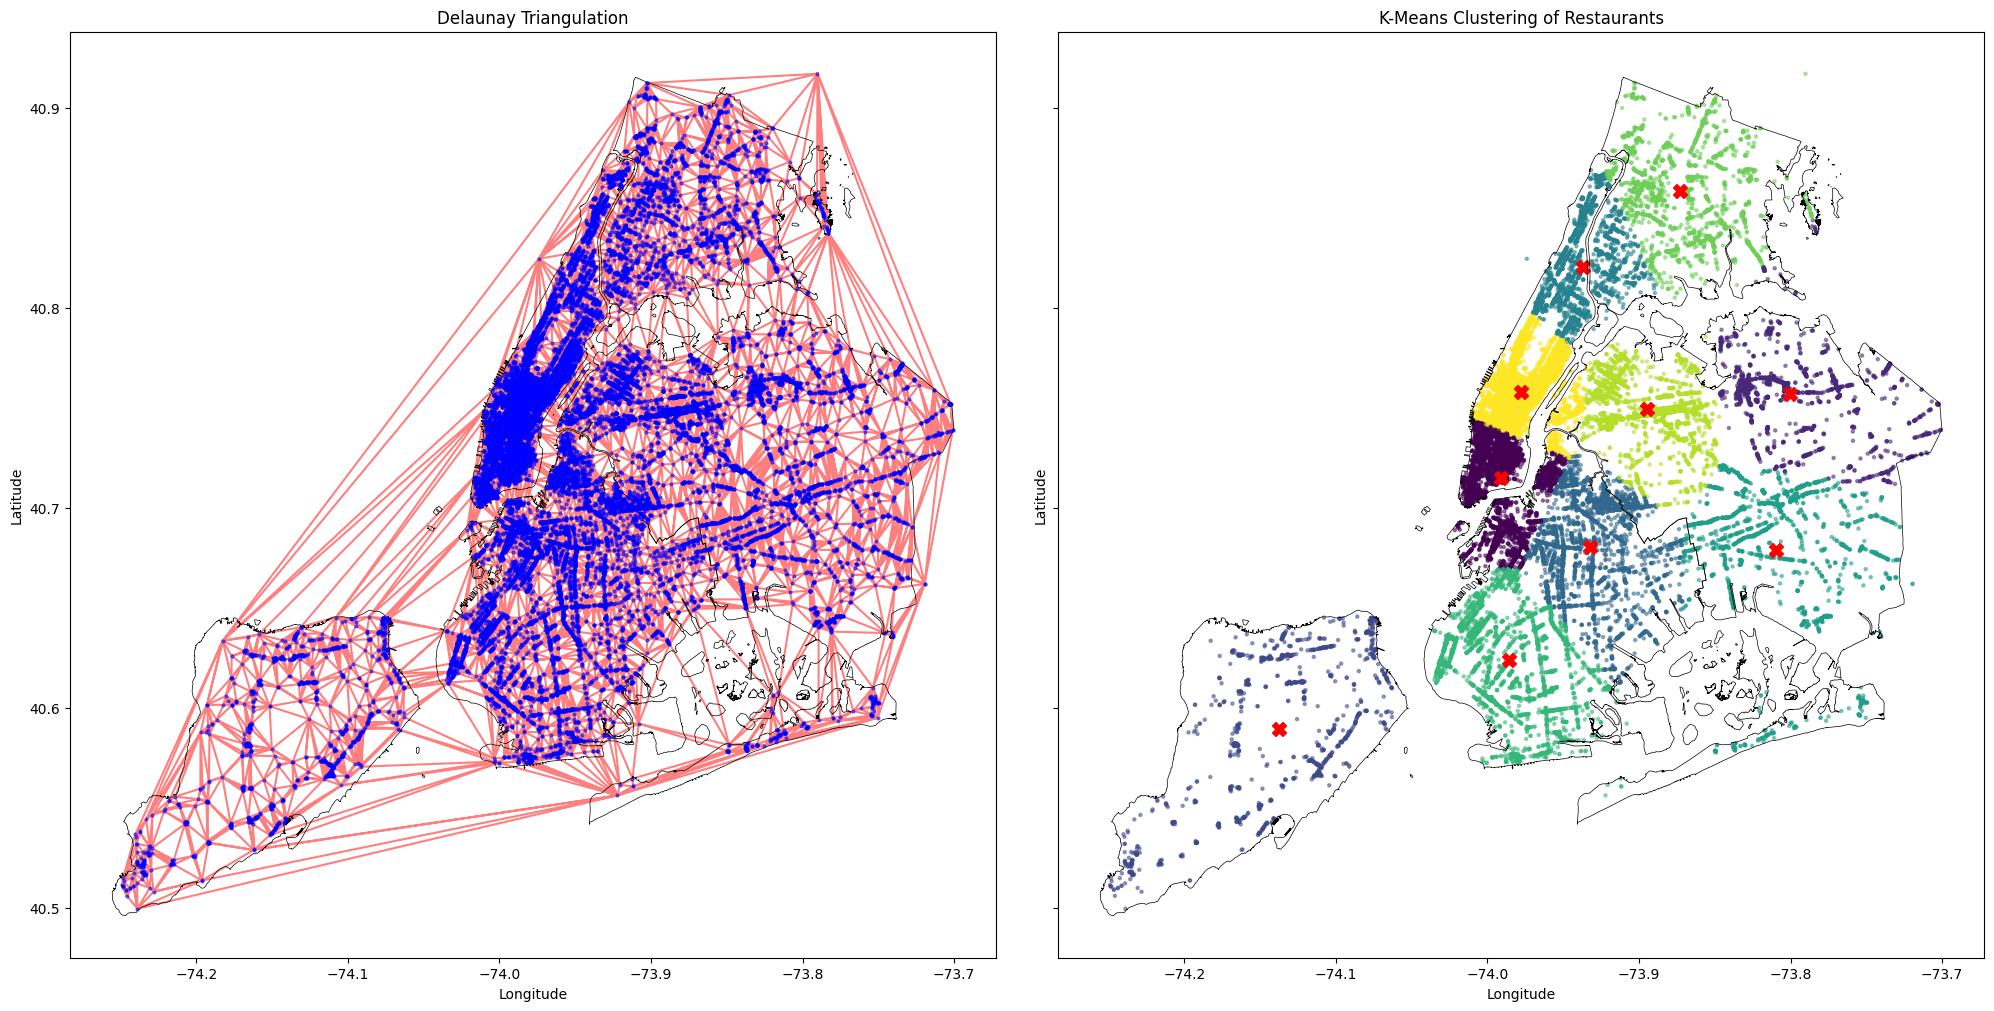

In [10]:
# Delaunay Triangulation and K-Means Plot
vs.plot_delaunay_triangulation_and_kmeans(gdf, nyc_boroughs, n_clusters=10)

# Part 3: Implementing Covering Algorithms and Measuring Performance

In the geometric set cover problem, we are given a universe of points and a collection of geometric shapes—in this case, disks—that can cover these points. The objective is to find the smallest subset of disks that covers all the points in the universe.

To begin, this dataset does not include a predefined set of disks. One heuristic for generating an initial set of disks that ensures every point is covered is as follows:

1. For each point in the dataset, create a disk centered at that point.
2. Set the radius of each disk to the distance required to encompass the 20 nearest neighboring points.

This approach guarantees that every point in the dataset is covered by at least one disk. While this initial set of disks will solve the coverage problem, it most likely not the optimal solution.

With the generated set of disks, a greedy algorithm or linear programming algorithm can be performed to obtain an optimal minimum subset.
1. The greedy algorithm simply chooses the disk with largest amount of uncovered points and deals with tie breakers by choosing the largest radius disk until all points are covered.
2. The linear programming algorithm implements a multiplicative weighting method and then returns an epsilon net. Further improvements could be made by using the geospatial features of the disks but would require geometric transformations, computational geometry libraries, and complicated geometric tools.

The size and time complexity of the greedy solution is acceptable with an approximately 10x total cost reduction from individual restaurant searches.


*Note: If you are skipping the data cleaning steps in part 1, ensure that the file path to the cleaned NYC restaurant data (CSV format) is updated accordingly in the next code cell.*

**Greedy Algorithm**

In [11]:
from utils import load_csv
import cover_algorithms as ca

cleaned_dataset_filepath = "cleaned_NYC_Restaurant_Database.csv"

df = load_csv(cleaned_dataset_filepath)
restaurants, restaurant_ids = ca.retrieve_restaurants_and_ids(df)
id_to_index, index_to_id = ca.create_id_mappings(restaurant_ids)

In [12]:
candidate_circles = ca.generate_candidate_circles(restaurants, index_to_id)
print(f"Total number of candidate circles: {len(candidate_circles)}")

# Ensure that all points are covered by the candidate circles
covered_by_candidates = set().union(*[circle['points_covered'] for circle in candidate_circles])
if covered_by_candidates != set(restaurant_ids):
    raise ValueError("Not all restaurants are covered by the candidate circles!")

Total number of candidate circles: 29266


In [13]:
#Greedy Set Cover Algorithm optimized with bucket deque
gc_selected_circles = ca.greedy_set_cover_bucket_queue(candidate_circles, restaurant_ids)
print(f"Greedy Set Cover Linear Time Solution, Number of selected circles: {len(gc_selected_circles)}")

covered_by_selected = set().union(*[circle['points_covered'] for circle in gc_selected_circles])
if covered_by_selected != set(restaurant_ids):
    raise ValueError("Not all restaurants are covered by the selected circles!")

Greedy Set Cover Linear Time Solution, Number of selected circles: 2734


In [14]:
#Greedy Set Cover Algorithm optimized with bucket deque prioritizing large radius
gcr_selected_circles = ca.greedy_set_cover_bucket_queue(candidate_circles, restaurant_ids, prioritize = True)
print(f"Greedy Set Cover nlogn Solution, Number of selected circles: {len(gcr_selected_circles)}")

covered_by_selected = set().union(*[circle['points_covered'] for circle in gcr_selected_circles])
if covered_by_selected != set(restaurant_ids):
    raise ValueError("Not all restaurants are covered by the selected circles!")

Greedy Set Cover nlogn Solution, Number of selected circles: 2626


**LP Approximation Algorithm**

In [15]:
X, Ranges, X_dual, R_dual_list = ca.transform_to_hitting_set_problem(restaurant_ids, candidate_circles)
optimal_set_cover = ca.hitting_set_search(X, Ranges, X_dual, R_dual_list)

In [16]:
lp_selected_circles = [candidate_circles[i] for i in optimal_set_cover]
print(f"LP Approximation Algorithm, Number of selected circles: {len(lp_selected_circles)}")

covered_by_selected = set().union(*[circle['points_covered'] for circle in lp_selected_circles])
if covered_by_selected != set(restaurant_ids):
    raise ValueError("Not all restaurants are covered by the selected circles!")

LP Approximation Algorithm, Number of selected circles: 3311


# Part 4: Visualizing Covering Algorithms

The graph below illustrates the coverage of the selected circles and highlights areas of overlap that can be optimized. This optimization can be achieved by generating a more refined selection of candidate circles and leveraging geospatial structures to improve the linear programming solution.

*Note: Part 3 must be run to create selected_circles.*

In [17]:
import os
from utils import load_csv
import visualizations as vs
import data_cleaning as dc

cleaned_dataset_filepath = "cleaned_NYC_Restaurant_Database.csv"

df = load_csv(cleaned_dataset_filepath)
gdf = vs.create_geodataframe(df)

if not os.path.exists('boroughs') and not os.path.exists('streets'):
    vs.download_streets_boroughs_shapefiles()
    
nyc_streets, nyc_boroughs = vs.load_shapefiles()

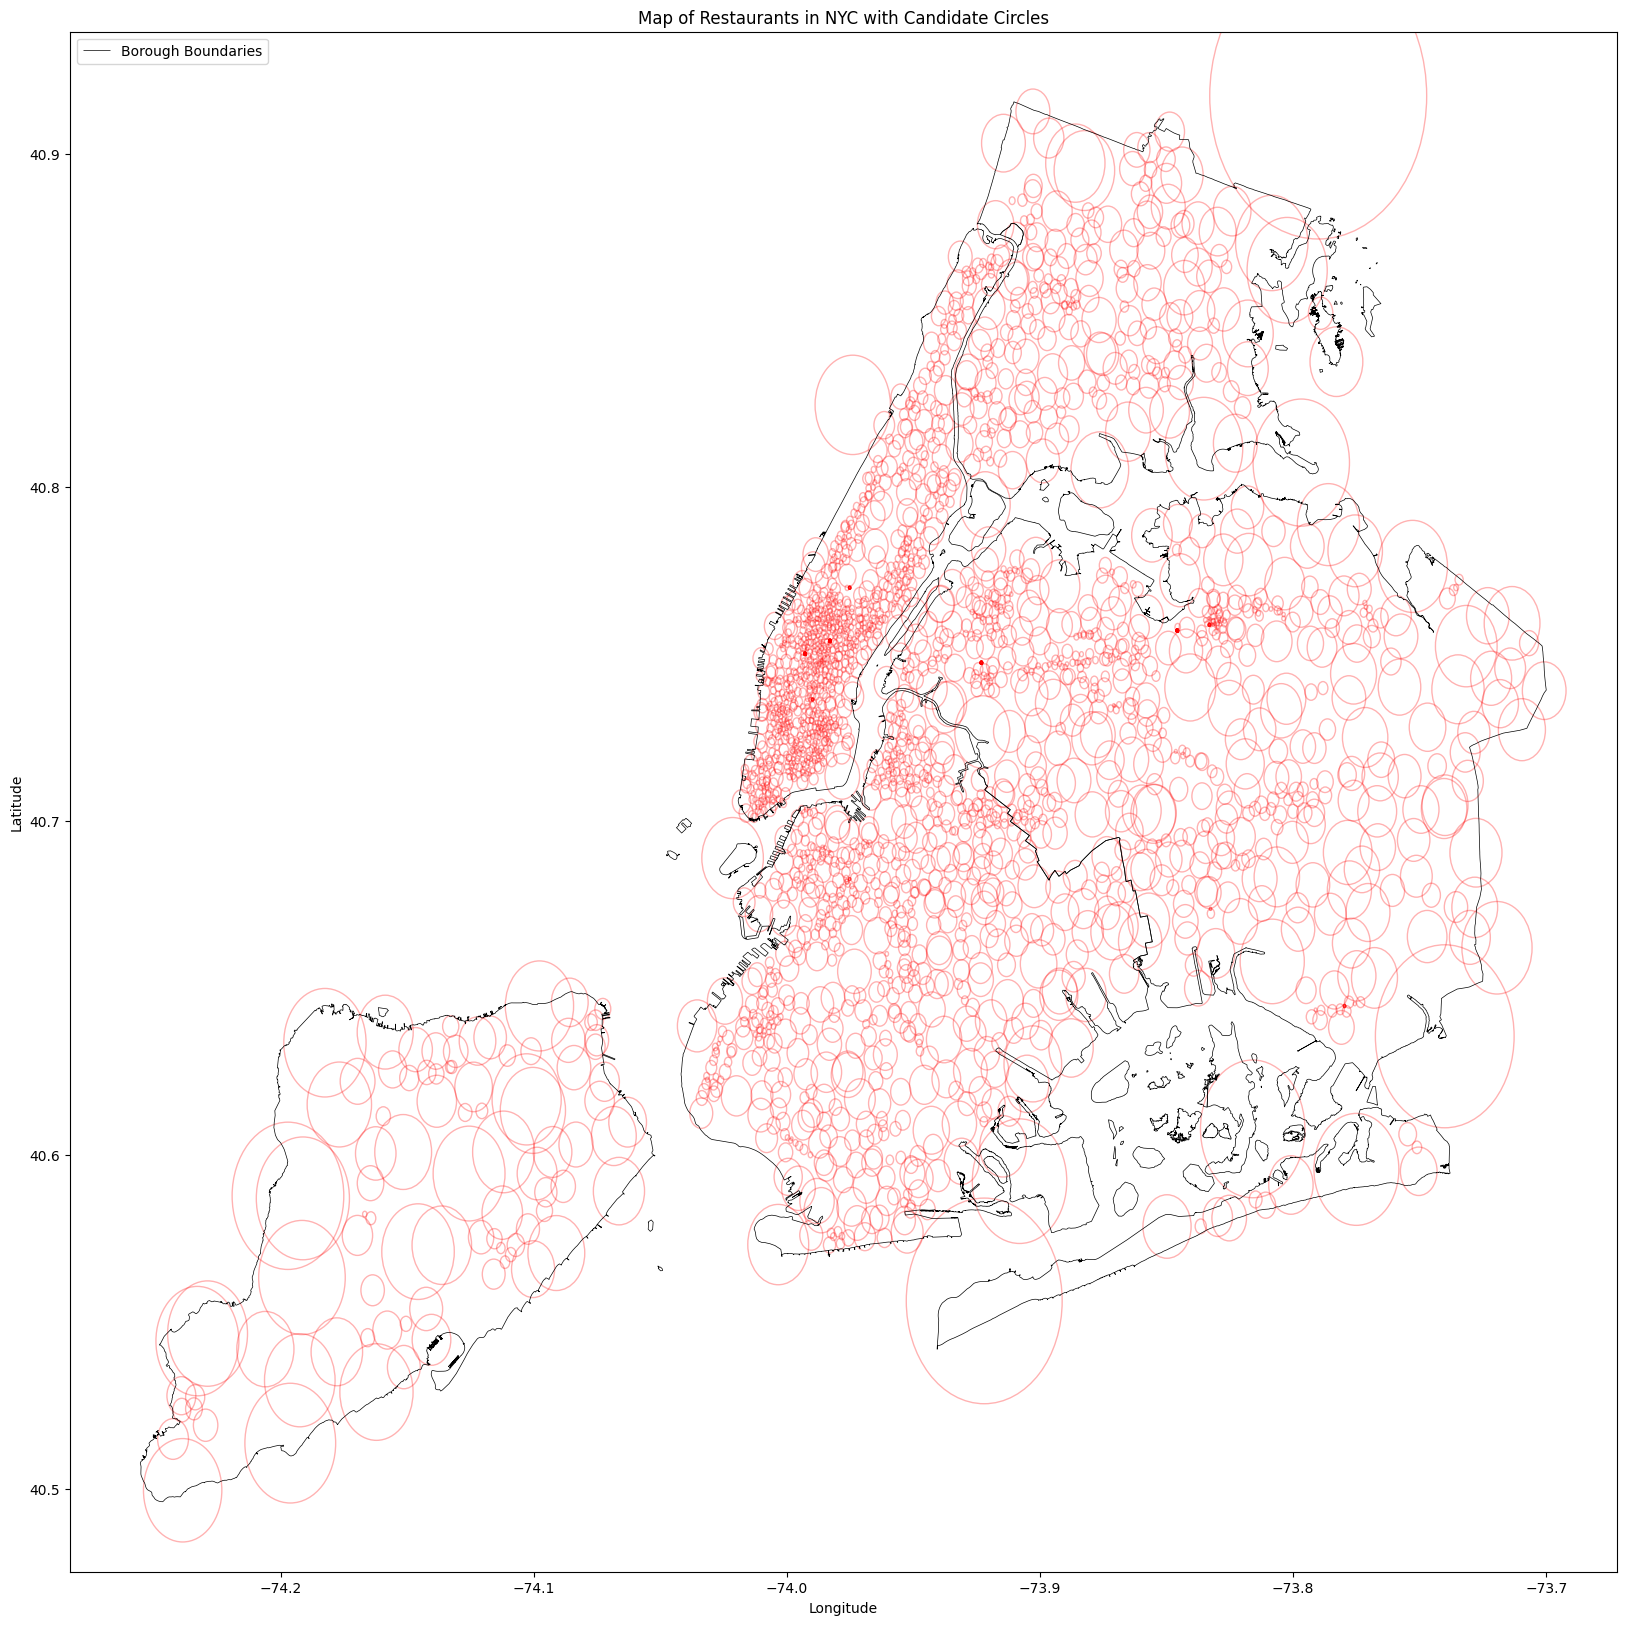

In [18]:
vs.plot_restaurant_distribution_with_circles(nyc_boroughs, gcr_selected_circles, figsize=(20, 20))

In [19]:
output_path = "nyc_coverage_api_calls.csv"
if not os.path.exists('output_path'):
    dc.write_dicts_to_csv(gcr_selected_circles, output_path)

# Analysis

To obtain these selected circles 10,000 geocodeing calls were made with a total cost of $50. The greedy algorithm is the most intuitive algorithm and the solution produced is within a constant of less than 2. Additionally, overlap between circles is not detrimental and can even enhance coverage, particularly in high-density locations. For future work, the highest-value improvement would be developing an algorithm to generate a larger set of candidate circles.

# Acknowledgments

This project uses code from [Bulk Geocoding with Geopy and GeoPanda](https://github.com/spatialthoughts/python-tutorials/geocoding_with_geopy.ipynb), which is licensed under the MIT License.

[Greedy Set Cover Algorithm Pseudocode](https://www.cs.ucr.edu/~neal/2004/cs260-static-mirror/wiki.pl%3Faction=browse&id=SetCoverByGreedyFast&revision=2.html)

[Haversine Forumla](https://community.esri.com/t5/coordinate-reference-systems-blog/distance-on-a-sphere-the-haversine-formula/ba-p/902128)

Agarwal, P. K., & Pan, J. (2014). Near-Linear Algorithms for Geometric Hitting Sets and Set Covers. Annual Symposium on Computational Geometry - SOCG’14. doi:10.1145/2582112.2582152 
Chan

Chan, T. M., & He, Q. (2020). Faster approximation algorithms for geometric set cover. CoRR, abs/2003.13420. https://arxiv.org/abs/2003.13420
